## Final Assignment - Intrusion detection

### Introduction 
Security is an important issue in today's environments.  
An intrusion detection system (IDS) is a model that can be used to analyze anomalous behavior in a network. NSL-KDD is the updated version of KDD cup 99 dataset. It is used as a benchmark for researchers  to compare different types of Intrusion detection system (IDS) methods or build an intrusion detection system.  
An in depth analysis of the original dataset can be found on this [Tavallaee et al.](https://www.researchgate.net/publication/48446353_A_detailed_analysis_of_the_KDD_CUP_99_data_set) and [Rawat et al.](https://arxiv.org/abs/1910.01114)

In [1]:
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
train_df = pd.read_csv('NSL-KDDTrain.csv')
test_df = pd.read_csv('NSL-KDDTest.csv')

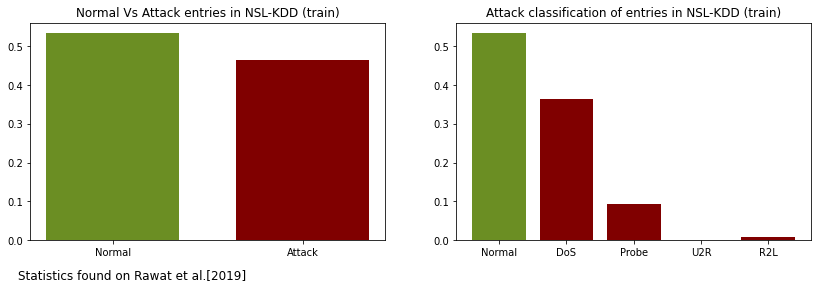

In [3]:
normal_attack = ['Normal', 'Attack']
normal_attack_height = [67343/train_df.shape[0], (train_df.shape[0]-67347)/train_df.shape[0]]

attack_type = ['Normal', 'DoS', 'Probe', 'U2R', 'R2L']
attack_type_height = [67343/train_df.shape[0], 45927/train_df.shape[0], 11656/train_df.shape[0], 52/train_df.shape[0] , 995/train_df.shape[0]]

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.bar(x=normal_attack, height=normal_attack_height, width=0.7, color=['olivedrab','maroon'])
plt.title('Normal Vs Attack entries in NSL-KDD (train)')
plt.text(x=-0.5, y=-0.1, s='Statistics found on Rawat et al.[2019]', fontsize=12)

plt.subplot(122)
plt.bar(x=attack_type, height=attack_type_height, color=['olivedrab'] + ['maroon']*4)
plt.title('Attack classification of entries in NSL-KDD (train)');

As suggested by the information presented in the graphs above, there is approximately the same number of attack and normal labels.   
So, to tackle the problem in an unlabel manner clustering techniques are suitable. Techniques that cluster the data either into two or five clusters can be used.  
A good clustering algorithm results in high intra cluster similarity and low inter cluster similarity. There are three major types of clustering
process according to the way they organize data:  
* Hierarchical
* Partitioning
* Mixture model methods

### Fast exploration of the attribuutes
There are three different types of attribuutes
* Floats
* Integers
* Character

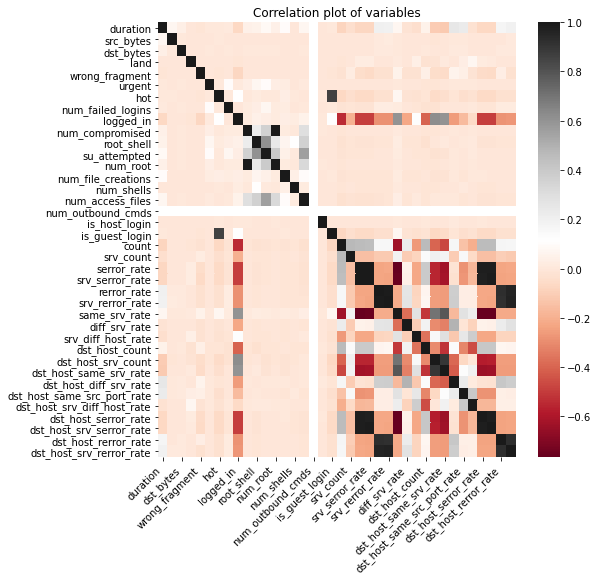

In [4]:
train_df_num = train_df[[col for col, dtype in zip(train_df.columns, train_df.dtypes=='object') if not dtype]]
corr_df = train_df_num.corr()

plt.figure(figsize=(8,8))
ax = sns.heatmap(
      corr_df, 
      cmap='RdGy'
    )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('Correlation plot of variables');

In [5]:
# cor_vars = [col for col, cor in zip(corr_df.columns, ((abs(corr_df)>0.4) & (corr_df<1)).any()) if cor]
# train_df_min = train_df_num[cor_vars]

# sns.pairplot(train_df_min)

Some of the variables are highly correlated with each other.  
We can reduce the dimensions of the dataset using a dimensionality reduction technique such as PCA.

In [7]:
scaler = StandardScaler ()
train_df_num = scaler.fit_transform(train_df_num)

In [19]:
y_act = test_df['target']
test_df_num = test_df[[col for col, dtype in zip(test_df.columns, test_df.dtypes=='object') if not dtype]]
test_df_num = scaler.transform(test_df_num)

In [17]:
from sklearn.cluster import KMeans

In [20]:
model = KMeans(n_clusters=2)
# fit model and predict clusters
model.fit(train_df_num)
yhat = model.predict(test_df_num)

In [24]:
y_act.value_counts()

attack    12833
normal     9711
Name: target, dtype: int64

In [14]:
from sklearn.decomposition import TruncatedSVD

In [15]:
svd = TruncatedSVD(n_components=20)
svs = svd.fit_transform(train_df_num)

In [6]:
# num_data = data[[col for col in data.columns if col not in ['protocol_type', 'service', 'flag']]]
# char_data = data[['protocol_type', 'service', 'flag']]

In [7]:
# num_data_test = data_test[[col for col in data_test.columns if col not in ['protocol_type', 'service', 'flag', 'target']]]
# y_test_actual = data_test['target']

In [8]:
# scaler = MinMaxScaler()
# num_data = scaler.fit_transform(num_data)
# num_data_test = scaler.transform(num_data_test)

# char_data = pd.get_dummies(char_data)

In [9]:
# data = pd.concat([pd.DataFrame(num_data), char_data], axis=1)

In [10]:
# #X_train = data.to_numpy()
# X_train = num_data
# X_test = num_data_test

In [11]:
# X_train.shape

In [12]:
# clf1 = AutoEncoder(hidden_neurons =[38, 14, 38])
# clf1.fit(X_train)

In [13]:
# y_train_scores = clf1.decision_scores_  

In [14]:
# # Predict the anomaly scores
# y_test_scores = clf1.decision_function(X_test)  # outlier scores
# y_test_scores = pd.Series(y_test_scores)

In [15]:
# plt.hist(y_test_scores, bins='auto')  
# plt.title("Histogram for Model Clf1 Anomaly Scores")
# plt.show()

In [16]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
import matplotlib.pyplot as plt 


In [17]:
data = pd.read_csv('NSL-KDDTrain.csv')
data_test = pd.read_csv('NSL-KDDTest.csv')

In [18]:
num_data = data[[col for col in data.columns if col not in ['protocol_type', 'service', 'flag']]]
char_data = data[['protocol_type', 'service', 'flag']]

num_data_test = data_test[[col for col in data_test.columns if col not in ['protocol_type', 'service', 'flag', 'target']]]
y_test_actual = data_test['target']

In [19]:
scaler = MinMaxScaler()
num_data = scaler.fit_transform(num_data)
num_data_test = scaler.transform(num_data_test)

char_data = pd.get_dummies(char_data)

In [20]:
X_train = num_data
X_test = num_data_test

In [21]:
# model = AgglomerativeClustering(n_clusters=2)
# # fit model and predict clusters
# model.fit(X_train)
# yhat = model.predict(X_test)

In [1]:
# model = Birch(threshold=0.01, n_clusters=2)
# # fit model and predict clusters
# model.fit(X_train)
# yhat = model.predict(X_test)